<img src="zona_jobs.png">

# Trabajo Práctico N° 1: Análisis Exploratorio


## 1. Preparación de los datos

### 1.1. Importación de Librerías

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
import cufflinks as cf
import plotly.plotly as py
warnings.filterwarnings('ignore')
import plotly
plotly.tools.set_credentials_file(username='soyarielruiz', api_key='Io0U7KvMLYpCw01a1vNJ')
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

### 1.2. Carga de Archivos

In [6]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
})

### 1.3. Ajustes de los Archivos antes de procesar

In [7]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)

In [8]:
# Agrupo las áreas parecidas.
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

In [9]:
# Convierto el nombre del area a category.
avisos_detalles['nombre_area'] = avisos_detalles['nombre_area'].astype('category')

In [10]:
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)
post_gen_edad['edad'] = (now - pd.to_datetime(post_gen_edad['fechanacimiento'])).astype('<m8[Y]')

In [11]:
# Renombramos algunas columnas para unificar criterios.
vistas.rename(columns={"idAviso":"idaviso"}, inplace=True)
vistas.rename(columns={"timestamp":"fechavista"}, inplace=True)

# Cambiar el tipo de dato de la fecha de vista.
vistas[['fechavista']] = vistas[['fechavista']].apply(pd.to_datetime)

### 1.4. Ajustes de los Archivos antes de procesar

In [12]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa (la de nivel academico mas alto) de cada postulante.
valores_educacion = pd.DataFrame({
    'nombre': ['Otro',  'Otro',  'Otro',  'Secundario',  'Secundario',  'Secundario',  'Terciario/Técnico', 'Universitario',  \
              'Terciario/Técnico', 'Universitario',  'Terciario/Técnico', 'Universitario',  'Posgrado', 'Master','Posgrado', \
              'Master','Posgrado', 'Master','Doctorado','Doctorado','Doctorado'],
    'estado': ['Abandonado', 'En Curso','Graduado','Abandonado', 'En Curso','Graduado','Abandonado', 'Abandonado', 'En Curso',\
              'En Curso','Graduado','Graduado','Abandonado', 'Abandonado', 'En Curso','En Curso','Graduado','Graduado',\
              'Abandonado', 'En Curso','Graduado'],
    'valor_educacion': [1 , 2 , 3 , 4, 5,6 ,7 ,8 ,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]})

# Y le pongo las mismas categorias que ya habia encontrado previamente.
valores_educacion.nombre = valores_educacion.nombre.astype((pd.api.types.CategoricalDtype(post_educacion.nombre.cat.categories)))
valores_educacion.estado = valores_educacion.estado.astype((pd.api.types.CategoricalDtype(post_educacion.estado.cat.categories)))

In [13]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion, how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [14]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()

# Controlo cuantas lineas me devolvio.
# max_post_educacion.count()

In [15]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], \
                          right_on = ['idpostulante','valor_educacion'])

# post_educacion.count()

In [20]:
post_educacion_graph = post_educacion.groupby(['nombre', 'estado', 'valor_educacion'])['idpostulante'].count().reset_index()
post_educacion_graph['resumen'] = post_educacion_graph.nombre.astype('object') + ' ' + post_educacion_graph.estado.astype('object')
post_educacion_graph.sort_values('valor_educacion', inplace=True)
post_educacion_graph.reset_index()
post_educacion_graph.drop(['nombre', 'estado', 'valor_educacion'], axis=1, inplace=True)
post_educacion_graph.rename(columns= {'idpostulante' : 'Cantidad de Postulantes'}, inplace=True)

# post_educacion_graph.head(22)

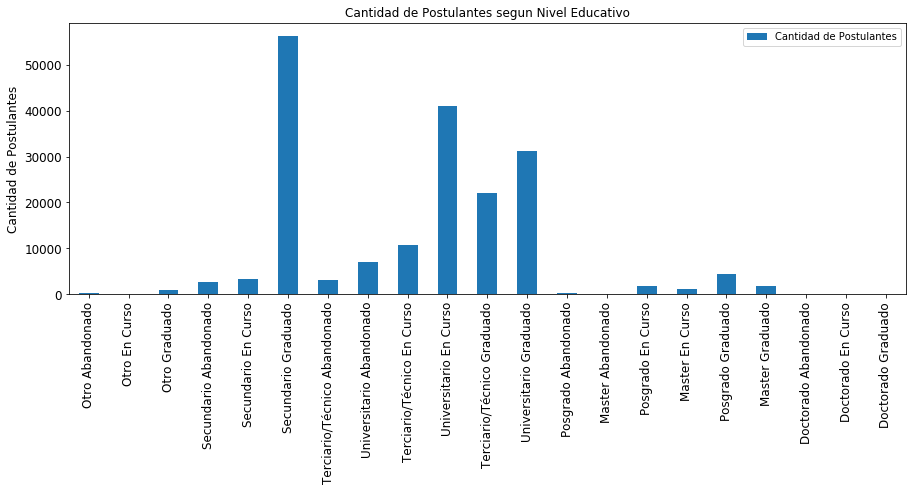

In [19]:
post_educacion_graph2 = post_educacion_graph[['resumen','Cantidad de Postulantes']].plot(kind='bar', x = 'resumen',                                                           
                                                           title ="Cantidad de Postulantes segun Nivel Educativo", 
                                                           figsize=(15, 5), legend=True, fontsize=12)
post_educacion_graph2.set_xlabel("", fontsize=12)
post_educacion_graph2.set_ylabel("Cantidad de Postulantes", fontsize=12)
plt.show()

In [3]:
post_educacion.head()

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universitario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


In [4]:
post_gen_edad.head()

,idpostulante,fechanacimiento,sexo
0,NM5M,1970-12-03,FEM
1,5awk,1962-12-04,FEM
2,ZaO5,1978-08-10,FEM
3,NdJl,1969-05-09,MASC
4,eo2p,1981-02-16,MASC


In [5]:
vistas.head()

,idAviso,timestamp,idpostulante
0,1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z
1,1112263876,2018-02-23T13:38:14.296-0500,BmVpYoR
2,1112327963,2018-02-23T13:38:14.329-0500,wVkBzZd
3,1112318643,2018-02-23T13:38:17.921-0500,OqmP9pv
4,1111903673,2018-02-23T13:38:18.973-0500,DrpbXDP


In [6]:
postulaciones.head()

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [7]:
avisos.head()

,idaviso
0,1112355872
1,1112335374
2,1112374842
3,1111984070
4,1111822480


In [8]:
avisos_detalles.head()

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR
1,17903700,1,Enfermeras,<p>Solicitamos para importante cadena de farma...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste
2,1000150677,1,Chofer de taxi,<p>TE GUSTA MANEJAR? QUERES GANAR PLATA HACIEN...,Capital Federal,NaN,Empedrado 2336,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,<p><strong>OPERARIOS DE PLANTA</strong></p><p>...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Producción,ELECTRO OUTLET SRL


In [9]:
avisos_detalles.columns.values

array(['idaviso', 'idpais', 'titulo', 'descripcion', 'nombre_zona',
       'ciudad', 'mapacalle', 'tipo_de_trabajo', 'nivel_laboral',
       'nombre_area', 'denominacion_empresa'], dtype=object)

In [10]:
avisos_detalles.describe()

,idaviso,idpais
count,1.353400e+04,13534.0
mean,1.110816e+09,1.0
std,3.235817e+07,0.0
min,1.585950e+06,1.0
25%,1.112222e+09,1.0
50%,1.112279e+09,1.0
75%,1.112339e+09,1.0
max,1.112389e+09,1.0


In [11]:
#relacion avisos vs postulantes
post_avisos = pd.merge(avisos_detalles, postulaciones, on='idaviso', how='inner')
post_avisos.count()

idaviso                 3074206
idpais                  3074206
titulo                  3074206
descripcion             3074206
nombre_zona             3074206
ciudad                    10296
mapacalle                205497
tipo_de_trabajo         3074206
nivel_laboral           3074206
nombre_area             3074206
denominacion_empresa    3073956
idpostulante            3074206
fechapostulacion        3074206
dtype: int64

In [12]:
#avisos que no tienen postulantes
avisos_sin_post = pd.merge(avisos_detalles, postulaciones, on='idaviso', how='left')
avisos_sin_post = avisos_sin_post[avisos_sin_post['idpostulante'].isnull()]
avisos_sin_post.count()

idaviso                 2218
idpais                  2218
titulo                  2218
descripcion             2218
nombre_zona             2218
ciudad                    11
mapacalle                158
tipo_de_trabajo         2218
nivel_laboral           2218
nombre_area             2218
denominacion_empresa    2218
idpostulante               0
fechapostulacion           0
dtype: int64

In [13]:
#avisos que tienen postulantes
avisos_con_post = avisos_detalles.merge(avisos_sin_post, how='left', on='idaviso')
avisos_con_post = avisos_con_post[avisos_con_post['titulo_y'].isnull()]
avisos_con_post.count()

idaviso                   11316
idpais_x                  11316
titulo_x                  11316
descripcion_x             11316
nombre_zona_x             11316
ciudad_x                     36
mapacalle_x                 714
tipo_de_trabajo_x         11316
nivel_laboral_x           11316
nombre_area_x             11316
denominacion_empresa_x    11311
idpais_y                      0
titulo_y                      0
descripcion_y                 0
nombre_zona_y                 0
ciudad_y                      0
mapacalle_y                   0
tipo_de_trabajo_y             0
nivel_laboral_y               0
nombre_area_y                 0
denominacion_empresa_y        0
idpostulante                  0
fechapostulacion              0
dtype: int64

In [14]:
#avisos totales
avisos_detalles.count()

idaviso                 13534
idpais                  13534
titulo                  13534
descripcion             13534
nombre_zona             13534
ciudad                     47
mapacalle                 872
tipo_de_trabajo         13534
nivel_laboral           13534
nombre_area             13534
denominacion_empresa    13529
dtype: int64

In [15]:
avisos.count()

idaviso    5028
dtype: int64

In [16]:
postulaciones.count()

idaviso             3401623
idpostulante        3401623
fechapostulacion    3401623
dtype: int64

In [17]:
#cantidad de postulaciones por postulante
cant_post = postulaciones.loc[:,['idpostulante']]
cant_post = cant_post.merge(post_gen_edad,how='inner',on='idpostulante')
cant_post.head()

,idpostulante,fechanacimiento,sexo
0,NM5M,1970-12-03,FEM
1,NM5M,1970-12-03,FEM
2,NM5M,1970-12-03,FEM
3,NM5M,1970-12-03,FEM
4,5awk,1962-12-04,FEM


In [18]:
cant_post = cant_post.loc[:,['idpostulante']]
cant_post_group = cant_post.groupby(['idpostulante']).size()
cant_post_group.head()

idpostulante
0z5VvGv    34
0zB026d     3
0zB03O9    17
0zB08lq     1
0zB0NWY     1
dtype: int64

In [19]:
cant_post_group_sort = cant_post_group.sort_values(ascending=False)
cant_post_group_sort.head()

idpostulante
axmjOE     3166
6rQdqjl    1773
5Mwjak     1485
8MaQjP3    1414
4rNzLje    1213
dtype: int64

In [20]:
#agrego el sexo y fechanacimiento
cant_post_sexo = pd.DataFrame(cant_post_group_sort).reset_index()
cant_post_sexo = cant_post_sexo.merge(post_gen_edad, how='inner', on='idpostulante')
cant_post_sexo[["idpostulante", "cantidad_postulaciones", "fechanacimiento", "sexo"]] = \
    cant_post_sexo[["idpostulante", 0, "fechanacimiento", "sexo"]]

cant_post_sexo= cant_post_sexo[["idpostulante", "cantidad_postulaciones", "fechanacimiento", "sexo"]]  
cant_post_sexo.head(15)

,idpostulante,cantidad_postulaciones,fechanacimiento,sexo
0,axmjOE,3166,1980-07-14,MASC
1,6rQdqjl,1773,1985-08-07,MASC
2,5Mwjak,1485,1979-10-21,MASC
3,8MaQjP3,1414,1993-12-09,FEM
4,4rNzLje,1213,1993-06-25,FEM
5,KBzm0ZX,1176,1961-03-26,MASC
6,NzrpkBD,1099,1979-10-12,MASC
7,4rPx4jR,1059,1994-03-14,MASC
8,JBmav1r,1030,1987-08-23,FEM
9,jk5aQ1b,1013,1985-03-08,MASC
